In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.stats as stats
import scipy.special
#graphing
import matplotlib.pyplot as plt
#stats
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel

#import testing
import sys
sys.path.append("../")
import vuong_tests

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
beta0 = 2.
beta1 = 1.

def gen_data(beta0=beta0,beta1=beta1):
    nobs = 1000
    #parameters
    sigma = 1
    
    epsilon = stats.norm.rvs(loc=0,scale=sigma,size=nobs)
    #censor data below x<0?
    x = stats.norm.rvs(loc=-2,scale=1,size=nobs)
    y = beta0+ beta1*x + epsilon
    
    #censor
    y[y<=0] = 0
    return y,x,nobs


yn,xn,nobs = gen_data()
print(xn.shape)
print(sm.add_constant(xn).shape)
print(scipy.stats.mode(yn))

(1000,)
(1000, 2)
ModeResult(mode=array([0.]), count=array([512]))


In [12]:
class Tobit(GenericLikelihoodModel):
    
    def __init__(self, *args,cc=False,ols=False, **kwargs):
        super(Tobit,self).__init__(*args,**kwargs)
        self._set_extra_params_names(['var'])
        #self.start_params = np.array([1]*(self.exog.shape[1]+1))
        self.cc = cc
        self.ols = ols
        #self.start_params = np.array( range(1, (2*self.exog.shape[1]+2)))
        #2 sets of params for z, 1 for x, 2 variances...
    
    def loglikeobs(self, params):
        y = self.endog
        x = self.exog
        m = 1*(self.endog == 0) #missingness
        
        beta = params[0:-1]
        sigma2 = max(params[-1],1e-3)
        
        mu_y = np.matmul(x,beta)
        
        pr_y = stats.norm.logpdf( y, loc = mu_y, scale=np.sqrt(sigma2))
        pr_m = np.log(max(m.mean(),1e-4))
        
        if not self.cc:
            pr_m = stats.norm.logcdf( y, loc = mu_y, scale=np.sqrt(sigma2))

        if self.ols:
            return pr_y
        else:
            ll = (1-m)*pr_y + m*pr_m
            return ll
    


model1 =  Tobit(yn,sm.add_constant(xn))
model1_fit = model1.fit(disp=False)
print(model1_fit.summary())

model2 =  Tobit(yn,sm.add_constant(xn),ols=True)
model2_fit = model2.fit(disp=False)
print(model2_fit.summary())

                                Tobit Results                                 
Dep. Variable:                      y   Log-Likelihood:                -902.34
Model:                          Tobit   AIC:                             1809.
Method:            Maximum Likelihood   BIC:                             1818.
Date:                Tue, 24 Nov 2020                                         
Time:                        18:36:46                                         
No. Observations:                1000                                         
Df Residuals:                     998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9564      0.077     25.418      0.000       1.806       2.107
x1             0.9696      0.042     22.919      0.0

In [13]:
def compute_llr(yn,xn):
    
    #fit normal values
    model1 = Tobit(yn,sm.add_constant(xn))
    model1_fit = model1.fit(disp=False)
    ll1 = model1.loglikeobs(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,sm.add_constant(xn),ols=True)
    model2_fit = model2.fit(disp=False)
    ll2 = model2.loglikeobs(model2_fit.params)
    
    llr = ll1.sum() - ll2.sum()
    omega2 = (ll1- ll2).var()
    return llr,np.sqrt(omega2)

print(compute_llr(yn,xn))

(9.88476864522022, 0.6759144903849584)


boot 2.1653886687049972 0.37835375634456714 4.020808296622812 

1
regular 2.1653886687049972
1


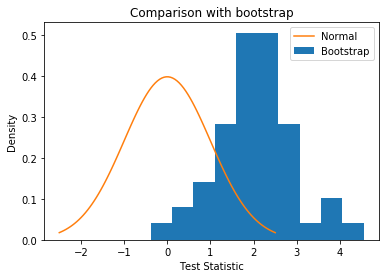

In [14]:
yn,xn,nobs = gen_data()
print(vuong_tests.bootstrap_test(yn,xn,nobs,compute_llr,hist=True))
print(vuong_tests.regular_test(yn,xn,nobs,compute_llr,hist=True))

plt.title("Comparison with bootstrap")
plt.xlabel("Test Statistic")
plt.ylabel("Density")
plt.legend()
plt.savefig('../figs/bootstrap_compare_tobit')
plt.show()

In [15]:
reg,boot,llr, omega = vuong_tests.monte_carlo(100,gen_data,compute_llr)
print("reg: %s, boot: %s, llr:%s, omega:%s"%(reg,boot,llr, omega))

regular 1.489398379725061
boot 1.489398379725061 0.21476874718456562 3.128294932188803 

31.40059761595603 0.6666947521132948 [1 0 0] [0 1 0]
------
regular 0.17502323787768037
boot 0.17502323787768037 -1.2900591681294205 2.3706200843967133 

3.5799268144057805 0.646812544865896 [2 0 0] [1 1 0]
------
regular 0.5734043182455039
boot 0.5734043182455039 -1.0494475466364193 2.2739798614342925 

11.597721843951263 0.639604822094684 [3 0 0] [2 1 0]
------
regular 2.63761372613397
boot 2.63761372613397 0.9052346521177741 4.199227466206971 

52.39144403742171 0.6281294771177023 [3 1 0] [2 2 0]
------
regular 1.3798613005253342
boot 1.3798613005253342 -0.4920832429615909 3.1234677067237944 

24.52864194247411 0.5621316897533418 [4 1 0] [3 2 0]
------
regular 2.9120819219184706
boot 2.9120819219184706 1.3419715315039191 4.417952062607102 

58.96432496965656 0.6403033039524286 [4 2 0] [3 3 0]
------
regular 2.4303931967800714
boot 2.4303931967800714 1.0192345138057712 4.318525345179206 

55.6605

KeyboardInterrupt: 

In [10]:
def setup_shi(yn,xn):
    model1 = Tobit(yn,xn)
    model1_fit = model1.fit( disp=False)
    k1 = len(model1_fit.params)
    ll1 = model1.loglikeobs(model1_fit.params)
    grad1 =  model1.score_obs(model1_fit.params)    
    hess1 = model1.hessian(model1_fit.params)
    
    #fit logistic values
    model2 = Tobit(yn,xn,ols=True)
    model2_fit = model2.fit(disp=False)
    k2 = len(model2_fit.params)
    ll2 = model2.loglikeobs(model2_fit.params)
    grad2 =  model2.score_obs(model2_fit.params)    
    hess2 = model2.hessian(model2_fit.params)
    
    return ll1,grad1,hess1,ll2,k1, grad2,hess2,k2

yn,xn,nobs = gen_data()
ll1,grad1,hess1,ll2,k1, grad2,hess2,k2 = setup_shi(yn,xn)

In [13]:
shi_result = vuong_tests.monte_carlo_shi(100,setup_shi,gen_data)
print(shi_result)

[0.97 0.03 0.  ]


In [ ]:
#reg: [0.89 0.11 0.  ], boot: [0.53 0.47 0.  ], llr:3.550072594684025, omega:0.09620388826704279